In [1]:
!pip install -r"../requirements.txt"


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_score, f1_score
from numpy.linalg import inv, pinv, LinAlgError
import io

In [3]:
# 1(a) 1. Vertebral Column Data Set
# This Biomedical data set was built by Dr. Henrique da Mota during a medical residence
# period in Lyon, France. Each patient in the data set is represented in the data set
# by six biomechanical attributes derived from the shape and orientation of the pelvis
# and lumbar spine (in this order): pelvic incidence, pelvic tilt, lumbar lordosis angle,
# sacral slope, pelvic radius and grade of spondylolisthesis. The following convention is
# used for the class labels: DH (Disk Hernia), Spondylolisthesis (SL), Normal (NO) and
# Abnormal (AB). In this exercise, we only focus on a binary classification task NO=0
# and AB=1.1
# (a) Download the Vertebral Column Data Set from: https://archive.ics.uci.
# edu/ml/datasets/Vertebral+Column.
# We're using the column_2C_weka.arff file

In [4]:
# (b) Pre-Processing and Exploratory data analysis:
# i. Make scatterplots of the independent variables in the dataset. Use color to
# show Classes 0 and 1.

In [5]:
#Load the raw .arff file
data_path = '../data/column_2C_weka.arff'

with open(data_path, 'r') as f:
    content = f.read()
#Split of the actual data part while skipping the header
data = content.split('@data')[1].strip()
df = pd.read_csv(io.StringIO(data), header = None)
df.columns = ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle',
                'sacral_slope', 'pelvic_radius', 'grade_of_spondylolisthesis', 'class']
# Convert class labels: Normal→0, Abnormal→1
df['class'] = df['class'].map({'Abnormal': 1, 'Normal': 0})

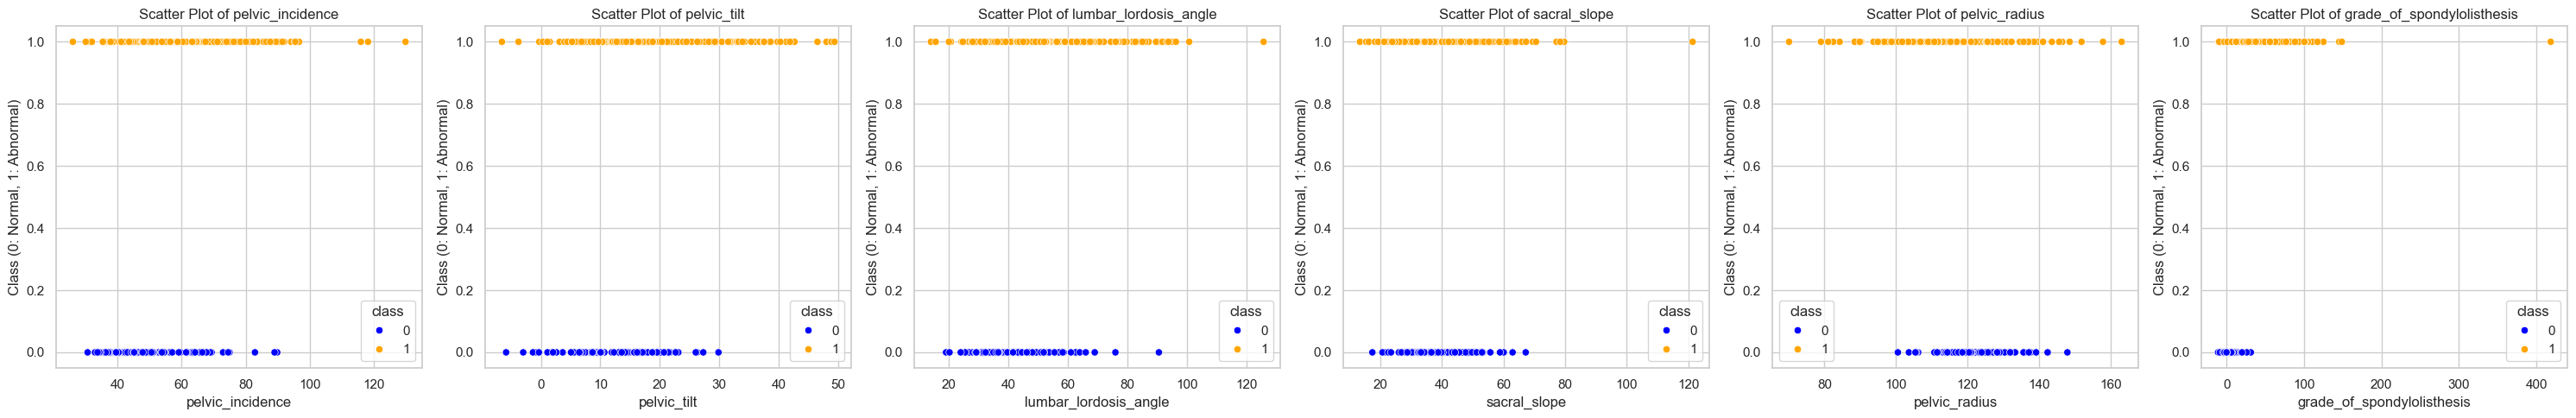

In [6]:
# Pick all columns except the last one (class) as features
independent_variables = df.columns[:-1]

sns.set(style = "whitegrid")
fig, axs = plt.subplots(1, 6, figsize = (30, 5))
axs = axs.flatten()

# looping through all independent features to plot scatterplot vs. class
for i, var in enumerate(independent_variables):
    sns.scatterplot(x = var, y = 'class', data = df, hue = 'class', palette = {0: 'blue', 1: 'orange'}, ax = axs[i])
    axs[i].set_title(f'Scatter Plot of {var}')
    axs[i].set_xlabel(var)
    axs[i].set_ylabel('Class (0: Normal, 1: Abnormal)')
plt.tight_layout()
plt.show()

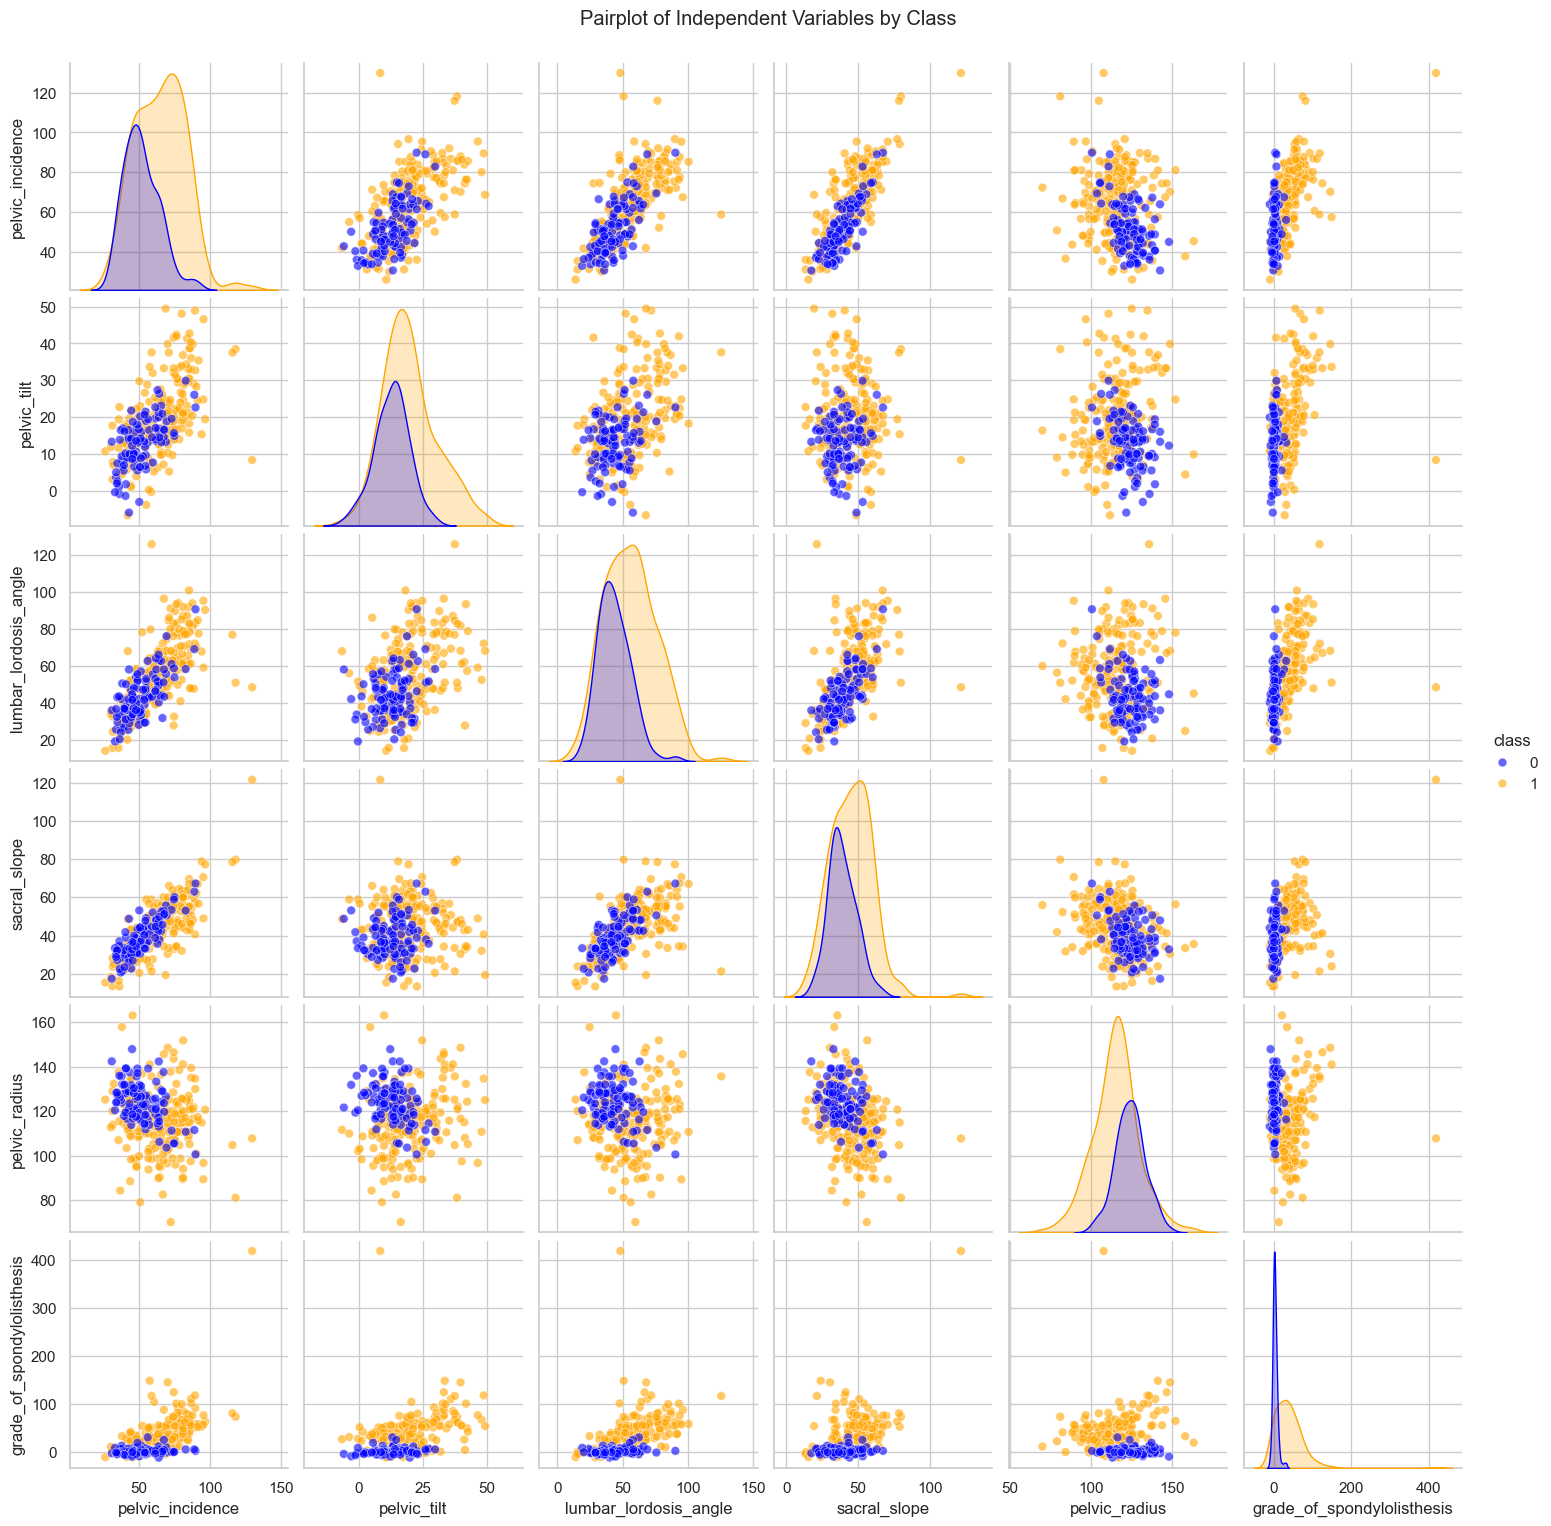

In [7]:
sns.set(style="whitegrid")
# Pairwise scatterplots of all features, colored by class
sns.pairplot(
    df,
    vars=independent_variables,   
    hue="class",                  
    palette={0: "blue", 1: "orange"},
    diag_kind="kde",              
    plot_kws={"alpha": 0.6, "s": 40} 
)
plt.suptitle("Pairplot of Independent Variables by Class", y=1.02)
plt.show()


In [8]:
# (b)
# ii. Boxplots

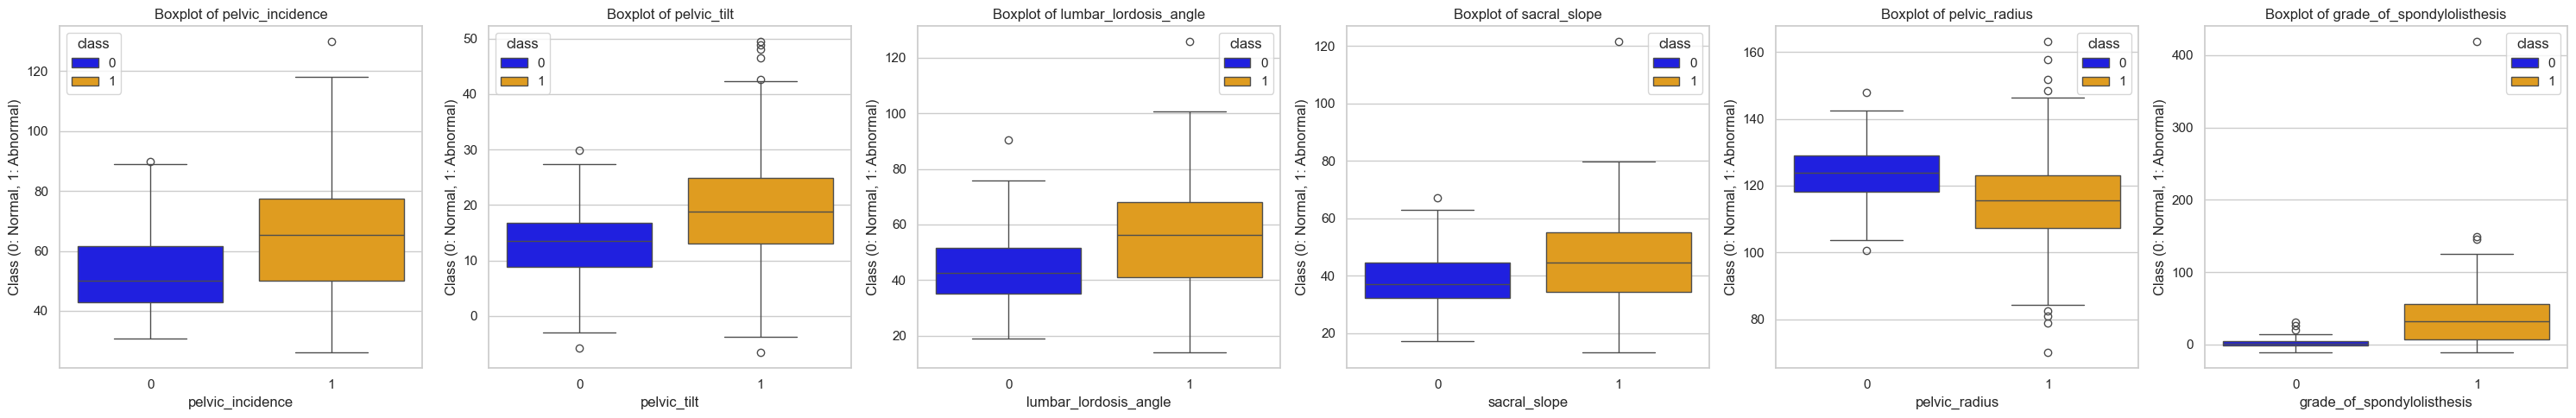

In [9]:
# Make one subplot per feature
fig, axs = plt.subplots(1, 6, figsize = (30, 5))
# Loop through features and draw boxplots split by class
for i, var in enumerate(independent_variables):
    sns.boxplot(
        x = 'class',
        y = var,
        data = df,
        hue = 'class',
        palette = {0: 'blue', 1: 'orange'},
        ax = axs[i]
    )
    axs[i].set_title(f'Boxplot of {var}')
    axs[i].set_xlabel(var)
    axs[i].set_ylabel('Class (0: Normal, 1: Abnormal)')
plt.tight_layout()
plt.show()

In [10]:
# (b)
# iii. Train and Test split

In [11]:
df0 = df[df['class'] == 0]
df1 = df[df['class'] == 1]

# Take first 70 normals and 140 abnormals for training
train0 = df0.iloc[:70]
train1 = df1.iloc[:140]
train_df = pd.concat([train0, train1], axis = 0)

# Use the rest for testing
test0 = df0.iloc[70:]
test1 = df1.iloc[140:]
test_df = pd.concat([test0, test1], axis = 0)

In [12]:
X_train = train_df.iloc[:, :-1].to_numpy()
y_train = train_df['class'].to_numpy()
X_test = test_df.iloc[:, :-1].to_numpy()
y_test = test_df['class'].to_numpy()
n_train = len(y_train)
print(f"Training Size: {n_train}, Test Size: {len(y_test)}")

Training Size: 210, Test Size: 100


In [13]:
# (c) i, and ii

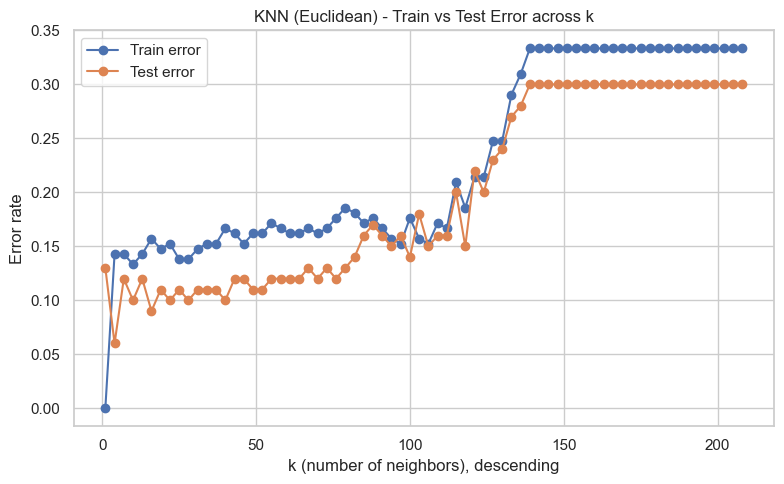

In [14]:
# Try different k values (from 208 down by 3)
k_values = [k for k in range(208, 0, -3) if k <=  n_train]

train_errors = []
test_errors = []

# Train KNN for each k and track errors
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors = k, metric = 'euclidean')
    knn.fit(X_train, y_train)
    train_pred = knn.predict(X_train)
    test_pred = knn.predict(X_test)
    train_error = 1 - (train_pred == y_train).mean()
    test_error = 1 - (test_pred == y_test).mean()
    train_errors.append(train_error)
    test_errors.append(test_error)

# Plot train vs test error curves
plt.figure(figsize = (8, 5))
plt.plot(k_values, train_errors, marker = 'o', label = 'Train error')
plt.plot(k_values, test_errors, marker = 'o', label = 'Test error')
plt.title('KNN (Euclidean) - Train vs Test Error across k')
plt.xlabel('k (number of neighbors), descending')
plt.ylabel('Error rate')
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
# Find best k* (the one with minimum test error)
min_error = min(test_errors)
best_idx = [i for i, e in enumerate(test_errors) if e == min_error][0]
k_star = k_values[best_idx]
print(f"\n Best k* = {k_star}, Test error = {min_error: .4f}")

# Train KNN with best k and get predictions
knn_best = KNeighborsClassifier(n_neighbors = k_star, metric = 'euclidean')
knn_best.fit(X_train, y_train)
y_best_pred = knn_best.predict(X_test)

# Build confusion matrix (class=1 first, then class=0), we are specifically mentioning classes 
# since sklearn's confusion matrix function automatically sorts the labels into [0, 1]
cm = confusion_matrix(y_test, y_best_pred, labels = [1, 0])
TP, FN, FP, TN = cm[0,0], cm[0,1], cm[1,0], cm[1,1]

# Calculate evaluation metrics
tpr = TP / (TP + FN) if (TP + FN) > 0 else float('nan')
tnr = TN / (TN + FP) if (TN + FP) > 0 else float('nan')
precision = precision_score(y_test, y_best_pred, pos_label = 1, zero_division = 0)
f1 = f1_score(y_test, y_best_pred, pos_label=1, zero_division=0)
accuracy = (TP + TN) / (TP + TN + FP + FN)

print("\nConfusion Matrix :")
print(cm)
print(f"Accuracy: {accuracy: .3f}")
print(f"True Positive rate: {tpr:.3f}")
print(f"True Negative rate: {tnr:.3f}")
print(f"Precision (class=1): {precision:.3f}")
print(f"F1-score (class=1): {f1:.3f}")


 Best k* = 4, Test error =  0.0600

Confusion Matrix :
[[69  1]
 [ 5 25]]
Accuracy:  0.940
True Positive rate: 0.986
True Negative rate: 0.833
Precision (class=1): 0.932
F1-score (class=1): 0.958


In [16]:
# We see that k = 4 gives the least test_error and so it is the most suitable among the k values

In [17]:
# (c) iii) Learning Curve

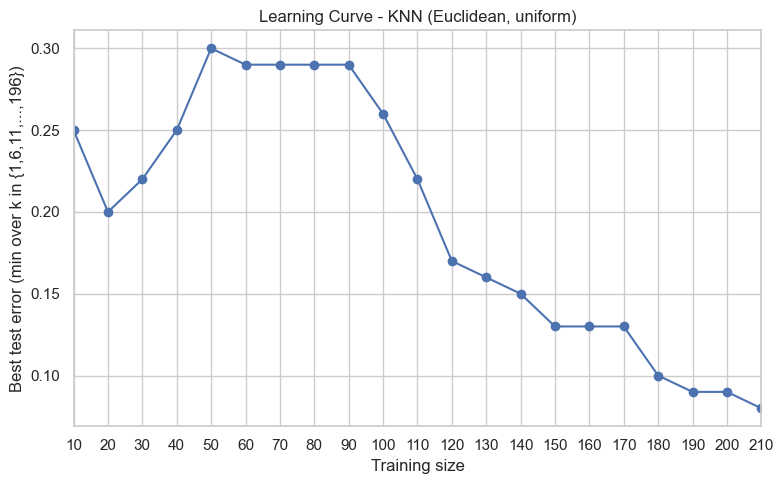

In [31]:
# Training sizes to test
Ns = list(range(10, 211, 10))
lc_errors = []

# Split training set by class for balanced sampling
t0_full = train_df[train_df['class'] == 0]
t1_full = train_df[train_df['class'] == 1]

for N in Ns:
    # ~1/3 class 0 and rest class 1
    n0 = N // 3
    n1 = N - n0
    sub_df = pd.concat([t0_full.iloc[:n0], t1_full.iloc[:n1]], axis = 0)
    X_sub = sub_df.iloc[:,:-1].to_numpy()
    y_sub = sub_df['class'].to_numpy()
    
    # Candidate k values (1,6,11,...,196) within training size
    k_candidates = [k for k in range(1, 197, 5) if k <= len(y_sub)]
    best_err = 1.0
    
    # Find best test error for this N
    for k in k_candidates:
        clf = KNeighborsClassifier(n_neighbors = k, metric = 'euclidean', weights = 'uniform')
        clf.fit(X_sub, y_sub)
        pred_sub = clf.predict(X_test)
        err = 1 - (pred_sub == y_test).mean()
        if err < best_err:
            best_err = err
    lc_errors.append(best_err)

# Plot learning curve
plt.figure(figsize = (8,5))
plt.plot(Ns, lc_errors, marker = 'o')
plt.xticks(Ns)
plt.xlim(10,210)
plt.xlabel("Training size")
plt.ylabel("Best test error (min over k in {1,6,11,...,196})")
plt.title("Learning Curve - KNN (Euclidean, uniform)")
plt.tight_layout()
plt.show()

In [19]:
# (d) 
# i. Minkowski Distance:
# A. which becomes Manhattan Distance with p = 1

In [20]:
# Search for best k using Manhattan distance (p=1)
best_err, best_k = 1.0, None
results_d = []
for k in range(1, 197, 5):
    if k > n_train: break
    if k == 1:    #Skipping k = 1 to avoid overfitting
        continue
    knn = KNeighborsClassifier(n_neighbors = k, metric = 'minkowski', p = 1)
    knn.fit(X_train, y_train)
    err = 1 - (knn.predict(X_test) == y_test).mean()
    # compute test error
    if err < best_err:
        best_err, best_k = err, k
results_d.append(["Manhattan (p=1)", best_k, best_err])
print(best_k)
print(best_err)

6
0.10999999999999999


In [21]:
# (d)
# i. Minkowski Distance:
# B. with log10(p) ∈ {0.1, 0.2, 0.3, . . . , 1}.

In [22]:
# Try different Minkowski p values (log10 scale)
log10_ps = [i/10 for i in range(1, 11)]
best_logp, best_err_m = None, 1.0
for logp in log10_ps:
    p_val = 10**logp   # convert log10(p) → actual p
    knn = KNeighborsClassifier(n_neighbors = best_k, metric = 'minkowski', p = p_val)
    knn.fit(X_train, y_train)

    # Test error for this p
    err = 1 - (knn.predict(X_test) == y_test).mean()
    if err < best_err_m:
        best_err_m, best_logp = err, logp
results_d.append([f"Minkowski (p=10^{best_logp:.1f})", best_k, best_err_m])
print(best_err_m)
print(best_logp)

0.06000000000000005
0.6


In [23]:
# (d)
# i) Minkowski distance:
# C. which becomes Chebyshev Distance with p → ∞

In [24]:
best_err, best_k = 1.0, None
for k in range(1, 197, 5):
    if k > n_train: break
    knn = KNeighborsClassifier(n_neighbors = k, metric = 'chebyshev')
    knn.fit(X_train, y_train)

    #test error
    err = 1 - (knn.predict(X_test) == y_test).mean()
    if err < best_err:
        best_err, best_k = err, k
results_d.append(["Chebyshev (p→∞)", best_k, best_err])
print(best_k)
print(best_err)

16
0.07999999999999996


In [25]:
# (d) ii. Mahalanobis Distance

In [26]:
# Compute covariance matrix of training data
cov = np.cov(X_train.T, bias=False)
VI = np.linalg.pinv(cov)  # pseudo-inverse for stability

# Search best k using Mahalanobis distance
best_err, best_k = 1.0, None
for k in range(1, 197, 5):
    if k > n_train: break
    knn = KNeighborsClassifier(n_neighbors=k, metric='mahalanobis', metric_params={'VI': VI})
    knn.fit(X_train, y_train)
    # Test error
    err = 1 - (knn.predict(X_test) == y_test).mean()
    if err < best_err:
        best_err, best_k = err, k
results_d.append(["Mahalanobis", best_k, best_err])
print(best_k)
print(best_err)

1
0.15000000000000002


In [27]:
df_results_d = pd.DataFrame(results_d, columns=["Metric", "Best k*", "Best Test Error"])
print("=== (d) Results ===")
print(
    df_results_d.to_string(
        index=False,
        formatters={"Best Test Error": "{:.4f}".format}
    )
)

=== (d) Results ===
              Metric  Best k* Best Test Error
     Manhattan (p=1)        6          0.1100
Minkowski (p=10^0.6)        6          0.0600
     Chebyshev (p→∞)       16          0.0800
         Mahalanobis        1          0.1500


In [28]:
# (e) Weighted decision

In [29]:
k_grid = [k for k in range(1, 197, 5) if k <= n_train]

# Helper: find best weighted KNN error for a given metric
def best_weighted_test_error(metric, *, p=None):
    best_err, best_k = 1.0, None
    for k in k_grid:
        if metric == 'minkowski':    # Manhattan is just p=1
            knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=p, weights='distance')
        else:
            knn = KNeighborsClassifier(n_neighbors=k, metric=metric, weights='distance')
        knn.fit(X_train, y_train)
        # test error (weighted voting)
        err = 1 - knn.score(X_test, y_test)
        # tie-breaker: smaller k wins
        if (err < best_err) or (err == best_err and (best_k is None or k < best_k)):
            best_err, best_k = err, k
    return best_err, best_k

eu_w_err, eu_w_k = best_weighted_test_error('euclidean')
man_w_err, man_w_k = best_weighted_test_error('minkowski', p=1)  # Manhattan
ch_w_err,  ch_w_k  = best_weighted_test_error('chebyshev')

results_e = pd.DataFrame([
    ["Euclidean (weighted)", eu_w_k, eu_w_err],
    ["Manhattan (weighted)", man_w_k, man_w_err],
    ["Chebyshev (weighted)", ch_w_k, ch_w_err],
], columns=["Metric", "Best k*", "Best Test Error"])

print("=== (e) Weighted voting: best test errors ===")
print(results_e.to_string(index=False, formatters={"Best Test Error": "{:.9f}".format}))

=== (e) Weighted voting: best test errors ===
              Metric  Best k* Best Test Error
Euclidean (weighted)        6     0.100000000
Manhattan (weighted)       26     0.100000000
Chebyshev (weighted)       16     0.110000000


In [30]:
# (f) The lowest training error rate achieved is 0.0 (perfect fit) at k = 1. Every training point uses itself as its nearest neighbor. 
# That means the classifier will always predict each training sample correctly → training error = 0.0.